# Predicting handwriting number with mnist

The model of mnist is generated using numpy/keras on Python.

```python
from tensorflow.contrib.keras.api.keras.datasets import mnist
from tensorflow.contrib.keras.api.keras.models import Sequential
from tensorflow.contrib.keras.api.keras.layers import Dense, Dropout, Activation
from tensorflow.contrib.keras.api.keras.optimizers import Adam
from tensorflow.contrib.keras.api.keras.utils import to_categorical
import tensorflow.contrib.lite as lite

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train  = x_train.reshape(60000, 784)
x_test   = x_test.reshape(10000, 784)
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')
x_train /= 255
x_test  /= 255
y_train  = to_categorical(y_train, 10)
y_test   = to_categorical(y_test, 10)

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
model.fit(x_train,y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_test, y_test))
model.save('mnist_model.h5')

converter = lite.TFLiteConverter.from_keras_model_file('mnist_model.h5')
tflite_model = converter.convert()
open('mnist_model.tflite', 'wb').write(tflite_model)
```

At the first, import packages.

In [1]:
import (
    "fmt"
    "image"
    _ "image/png"
    "log"
    "os"
)

And go-tflite

In [2]:
import "github.com/iAmPlus/go-tflite"

Load tflite model file that is generated by Python.

In [3]:
model := tflite.NewModelFromFile("mnist_model.tflite")
if model == nil {
    log.Fatal("cannot load model")
}

 Now you can create interpreter of TensorFlow Lite. The second argument is InterpreterOptions. If you want to specify thread number of the interpreter, modify options that created by NewInterpreterOptions.
 ```go
options := tflite.NewInterpreterOptions()
options.SetNumThread(4)
defer options.Delete()

interpreter := tflite.NewInterpreter(model, options)
```

In [4]:
interpreter := tflite.NewInterpreter(model, nil)

Allocate tensors according to the model.

In [5]:
if status := interpreter.AllocateTensors(); status != tflite.OK {
    log.Fatal("cannot allocate tensors")
}

Then, load an image file

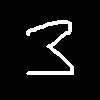

In [6]:
f, err := os.Open("3.png")
if err != nil {
    log.Fatal(err)
}
img, _, err := image.Decode(f)
if err != nil {
    log.Fatal(err)
}

Mnist images are cropped as 28x28 images. So the input image must be resized.

In [7]:
import "github.com/nfnt/resize"

In [8]:
resized := resize.Resize(28, 28, img, resize.NearestNeighbor)

You can update this slice directly. It can use built-in function copy().

In [9]:
in := interpreter.GetInputTensor(0).Float32s()
for y := 0; y < 28; y++ {
    for x := 0; x < 28; x++ {
        r, g, b, _ := resized.At(x, y).RGBA()
        in[y*28+x] = (float32(b) + float32(g) + float32(r)) / 3.0 / 65535.0
    }
}

Then, call `Invoke()`

In [10]:
if status := interpreter.Invoke(); status != tflite.OK {
    log.Fatal("invoke failed")
}

Now you can access output tensor.

In [11]:
out := interpreter.GetOutputTensor(0).Float32s()

`out` is slice of float32 numbers.

In [12]:
out

[1.2333634e-11 2.5768488e-05 2.6195408e-05 0.99993837 2.177349e-11 4.5343672e-06 1.0496123e-12 4.754279e-06 3.9681322e-07 5.7964775e-09]

The wanted number is encodeded as offset that Python encoded this number as 1 hot. Then, add function to get index of item which is largest number.

In [13]:
func top(a []float32) int {
    t := 0
    m := float32(0)
    for i, e := range a {
        if i == 0 || e > m {
            m = e
            t = i
        }
    }
    return t
}

Predicted number is...

In [14]:
fmt.Sprintf("The number written on the image is: %v", top(out))

The number written on the image is: 3